# Master Voice with WaveGAN (Without Post-Processing)

In [1]:
import decimal 
import tensorflow as tf
import os
from keras import backend as K
from keras.models import Model, load_model, Sequential
from keras.layers.core import Flatten, Reshape, Dense
from keras.layers import Input, Dot, Lambda
import librosa
from librosa import display
import logging
import math
import numpy as np
import operator
import pandas as pd
import pickle
import random
from scipy import spatial
from scipy.signal import lfilter
from scipy import signal
from scipy.io.wavfile import write
from IPython.display import display, Audio, HTML
import matplotlib.pyplot as plt
import soundfile as sf
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
def save_obj(obj,name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

## -- Acoustic Features Extraction: Spectrograms

In [3]:
acoustic_params = {'max_sec': 10,
                   'bucket_step': 1,
                   'frame_step': 0.01,
                   'sample_rate': 16000,
                   'preemphasis_alpha': 0.97,
                   'frame_len': 0.025,
                   'num_fft': 512}

In [4]:
def get_fft_spectrum(filename, params, audio_read):

    if audio_read == 'Yes':
        signal = load_wav(filename, params['sample_rate'])
    elif audio_read == 'No':
        signal = filename
    
    frames = framesig(signal, frame_len=params['frame_len'] * params['sample_rate'], frame_step=params['frame_step']*params['sample_rate'], winfunc=np.hamming)
    fft = abs(np.fft.fft(frames,n=params['num_fft']))
    fft_norm, fft_means, fft_stds = normalize_frames(fft.T)
    return fft_norm, fft_means, fft_stds

def load_wav(filename, sample_rate):
    audio, sr = librosa.load(filename, sr=sample_rate, mono=True)
    audio = audio.flatten()
    return audio

def framesig(sig, frame_len, frame_step, winfunc=lambda x: np.ones((x,)), stride_trick=True):
    slen = len(sig)
    frame_len = int(round_half_up(frame_len))
    frame_step = int(round_half_up(frame_step))
    if slen <= frame_len:
        numframes = 1
    else:
        numframes = 1 + int(math.ceil((1.0 * slen - frame_len) / frame_step)) # LV

    padlen = int((numframes - 1) * frame_step + frame_len)

    zeros = np.zeros((padlen - slen,))
    padsignal = np.concatenate((sig, zeros))
    if stride_trick:
        win = winfunc(frame_len)
        frames = rolling_window(padsignal, window=frame_len, step=frame_step)
    else:
        indices = np.tile(np.arange(0, frame_len), (numframes, 1)) + np.tile(np.arange(0, numframes * frame_step, frame_step), (frame_len, 1)).T
        indices = np.array(indices, dtype=np.int32)
        frames = padsignal[indices]
        win = np.tile(winfunc(frame_len), (numframes, 1))

    return frames * win

def deframesig(frames, siglen, frame_len, frame_step, winfunc=lambda x: np.ones((x,))):
    frame_len = round_half_up(frame_len)
    frame_step = round_half_up(frame_step)
    numframes = np.shape(frames)[0]
    assert np.shape(frames)[1] == frame_len, '"frames" matrix is wrong size, 2nd dim is not equal to frame_len'

    indices = np.tile(np.arange(0, frame_len), (numframes, 1)) + np.tile(
        np.arange(0, numframes * frame_step, frame_step), (frame_len, 1)).T
    indices = np.array(indices, dtype=np.int32)
    padlen = (numframes - 1) * frame_step + frame_len

    if siglen <= 0: siglen = padlen

    rec_signal = np.zeros((padlen,))
    window_correction = np.zeros((padlen,))
    win = winfunc(frame_len)

    for i in range(0, numframes):
        window_correction[indices[i, :]] = window_correction[
                                               indices[i, :]] + win + 1e-15  # add a little bit so it is never zero
        rec_signal[indices[i, :]] = rec_signal[indices[i, :]] + frames[i, :]

    rec_signal = rec_signal / window_correction
    return rec_signal[0:siglen]

    return frames * win

def normalize_frames(m,epsilon=1e-12):
    frames = []
    means = []
    stds = []
    for v in m:
        means.append(np.mean(v))
        stds.append(np.std(v))
        frames.append((v - np.mean(v)) / max(np.std(v), epsilon))
    return np.array(frames), np.array(means), np.array(stds)

def denormalize_frames(m, means, stds, epsilon=1e-12):
    return np.array([z * max(stds[i],epsilon) + means[i] for i, z in enumerate(m)])

def rolling_window(a, window, step=1):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)[::step]

def round_half_up(number):
    return int(decimal.Decimal(number).quantize(decimal.Decimal('1'), rounding=decimal.ROUND_HALF_UP))

## -- Bottleneck Features Extraction: VGGVox-Vectors

In [5]:
graph = tf.Graph()
sess = tf.Session(graph=graph)

In [6]:
# Creating Keras session
K.set_session(sess)

# Import VGG Vox pre-trained model
with graph.as_default():
    with tf.name_scope('VGG_Vox'):
        bottleneck = load_model('/beegfs/mm10572/voxceleb2/additional_material/vggvox.h5') 

## -- Training Dataset

In [7]:
# Pickle File: An array including a list of paths used for training: 50 utterances per person 
utterance_paths = load_obj('/beegfs/mm10572/voxceleb2/additional_material/train_vox2_abspaths_1000_users') 
utterance_paths[:2] # Sample data

['/beegfs/mm10572/voxceleb2/dev/id02331/6dSawXx_NNk/00033.m4a',
 '/beegfs/mm10572/voxceleb2/dev/id02331/LJdtecWIS3A/00066.m4a']

In [8]:
 # Pickle File: An array including a list of labels corresponding to paths in utterance_paths
utterance_labels = load_obj('/beegfs/mm10572/voxceleb2/additional_material/train_vox2_labels_1000_users')
utterance_labels[:2] # Sample data

[16, 16]

In [9]:
# Numpy File: A 2D matrix including embedding vectors for paths in utterance_paths
utterance_bottleneck_features = np.load('/beegfs/mm10572/voxceleb2/additional_material/train_vox2_embs_1000_users.npy') 
utterance_bottleneck_features[:2] # Sample data

array([[ 7.78697291e-03,  4.98584891e-03,  1.73048340e-02, ...,
         3.47861648e-02, -5.03421434e-05, -3.13258581e-02],
       [ 8.77610594e-03,  2.80432142e-02,  1.07790232e-02, ...,
         4.44943644e-02,  1.52959935e-02, -9.63459723e-03]])

In [10]:
user_id_position = 5
indexes_male_utterances = []
indexes_female_utterances = []
# CSV File: A CSV containing the metadata of the VoxCeleb2 dataset
vox_metadata = pd.read_csv('/beegfs/mm10572/voxceleb2/additional_material/vox2_meta.csv', header=None, names=['vid', 'vggid', 'gender', 'set']) 
for p_index, path in enumerate(utterance_paths):
    if (p_index+1) % 100 == 0:
        print('\rPath', p_index+1, '/', len(utterance_paths), end='')
    if vox_metadata.loc[vox_metadata.vid == path.split('/')[user_id_position], 'gender'].values[0] == 'm':
        indexes_male_utterances.append(p_index)
    else:
        indexes_female_utterances.append(p_index)

Path 50000 / 50000

## -- Optimization Parameters

In [11]:
batch_size = 16
n_iterations = 100
learning_rate = 1e-2
min_similarity = 0.25
max_similarity = 0.75
min_change = 1e-5
indexes_optimization = indexes_male_utterances

## -- Load WaveGAN

In [12]:
# Load WaveGAN graph
with graph.as_default():
    infer_path = os.path.abspath("/beegfs/kp2218/rename_test/infer/infer.meta")
    print('Path to infer.meta file:',infer_path)
    saver = tf.train.import_meta_graph(infer_path)

    ckpt_path = os.path.abspath("/beegfs/kp2218/rename_test/model.ckpt-62552")
    print('Path to .ckpt file:', ckpt_path)
    print('')
    saver.restore(sess, ckpt_path)

Path to infer.meta file: /beegfs/kp2218/rename_test/infer/infer.meta
Path to .ckpt file: /beegfs/kp2218/rename_test/model.ckpt-62552

INFO:tensorflow:Restoring parameters from /beegfs/kp2218/rename_test/model.ckpt-62552


## -- Audio Processing Parameters

In [13]:
# Speaker IR
ir_speaker_dir = '/beegfs/kp2218/test_runs/conv_test/data/audio/ir_speaker/IR_ClestionBD300.wav'
ir_speaker, fs_speaker = librosa.load(ir_speaker_dir, sr=16000, mono=True)

# Microphone IR
ir_mic_dir = '/beegfs/kp2218/test_runs/conv_test/data/audio/ir_mic/IR_OktavaMD57.wav'
ir_mic, fs_mic = librosa.load(ir_mic_dir, sr=16000, mono=True)

# Room IR
ir_room_dir = '/beegfs/kp2218/test_runs/conv_test/data/audio/ir_room/BRIR.wav'
ir_room, fs_room = librosa.load(ir_room_dir, sr=16000, mono=True)

# Filter parameters
nyq = 0.5 * 16000
low_value = 100
high_value = 7000
low_cutoff = low_value / nyq
high_cutoff = high_value / nyq

## -- Main Function (WaveGAN + Post-proccessing)

In [14]:
def gan_audio_generator(z):

    # WaveGAN audio generator
    G_z = graph.get_tensor_by_name('G_z:0')
    
    return G_z


def audio_post_processing(G_z):
    
    with tf.name_scope("post_processing") as scope:
        
        '''
        ------- Speaker IR Convolution -------
        '''
            
        # Convolve with Speaker IR
        ir_speaker_tensor = tf.placeholder(dtype=tf.float32, shape=[None], name="Speaker_Tensor")
        ir_speaker_tensor = tf.expand_dims(ir_speaker_tensor, 1)
        ir_speaker_tensor = tf.expand_dims(ir_speaker_tensor, 2)
        
        # Zero pad with speaker IR shape
        pad_len_speaker = int(len(ir_speaker)/2 -1)
        pad_speaker_value = tf.constant([[0,0], [pad_len_speaker,pad_len_speaker+1], [0,0]], name="Speaker_Pad")
        G_z = tf.pad(G_z, pad_speaker_value, "CONSTANT")

        speaker_out = tf.nn.conv1d(G_z, ir_speaker_tensor, 1, padding="VALID", name="Speaker_Out")
        
        '''
        ------- Noise Parameter -------
        '''
        
        # Add noise
        s = speaker_out.get_shape().as_list()
        noise_tensor = tf.random.normal([1,65536,1], mean=0, stddev=5e-3, dtype=tf.float32, name="Noise_param")
        
        # ** Add filter **
        
        speaker_out = tf.add(speaker_out, noise_tensor, name="Speaker_plus_Noise")

        '''
        ------- Room IR Convolution -------
        '''
        
        # Convolve with Room IR
        ir_room_tensor = tf.placeholder(dtype=tf.float32, shape=[None], name="Room_Tensor")
        ir_room_tensor = tf.expand_dims(ir_room_tensor, 1)
        ir_room_tensor = tf.expand_dims(ir_room_tensor, 2)
        
        # Zero pad with Room IR shape
        pad_len_room = int(len(ir_room)/2 -1)
        pad_room_value = tf.constant([[0,0], [pad_len_room,pad_len_room+1], [0,0]])
        speaker_out = tf.pad(speaker_out, pad_room_value, "CONSTANT", name="Room_Pad")
        
        room_out = tf.nn.conv1d(speaker_out, ir_room_tensor, 1, padding="VALID", name="Room_Out")

        '''
        ------- Mic IR Convolution -------
        '''
        
        # Convolve with Mic IR
        ir_mic_tensor = tf.placeholder(dtype=tf.float32, shape=[None], name="Mic_Tensor")
        ir_mic_tensor = tf.expand_dims(ir_mic_tensor, 1)
        ir_mic_tensor = tf.expand_dims(ir_mic_tensor, 2)
        
        # Zero pad with Mic IR shape
        pad_len_mic = int(len(ir_mic)/2 -1)
        pad_mic_value = tf.constant([[0,0], [pad_len_mic,pad_len_mic+1], [0,0]], name="Mic_Pad")
        room_out = tf.pad(room_out, pad_mic_value, "CONSTANT")
        
        audio_out = tf.nn.conv1d(room_out, ir_mic_tensor, 1, padding="VALID", name="Audio_Out")

        return audio_out
    
def spectrogram_conversion(audio_out):
    
    with tf.name_scope("spectrogram_conv") as scope:
        
        # Converting audio tensor to frames
        frames = tf.contrib.signal.frame(audio_out[0,:,0],
                                         frame_length=int(acoustic_params['frame_len'] * acoustic_params['sample_rate']),
                                         frame_step=int(acoustic_params['frame_step'] * acoustic_params['sample_rate']),
                                         pad_end=True,
                                         name="Frames")
        
        # Windowing each frame
        frames = frames * tf.contrib.signal.hamming_window(int(acoustic_params['frame_len'] * acoustic_params['sample_rate']), periodic=True)

        frames = tf.transpose(frames)

        t = tf.shape(frames)

        # Zero padding for FFT
        pad_amount = tf.zeros([int(acoustic_params['num_fft'])-int(acoustic_params['frame_len'] * acoustic_params['sample_rate']),
                                   t[1]], tf.float32)

        frames_pad = tf.concat([frames, pad_amount], axis=0)

        # Computing the FFT of the audio tensor
        y = tf.cast(frames_pad, tf.complex64)
        y = tf.transpose(y)

        spec = tf.cast(tf.abs(tf.spectral.fft(y, name="FFT")), tf.float32)
        mag_spec = tf.transpose(spec)

        # Normalizing the spectrogram
        mean_tensor, variance_tensor = tf.nn.moments(mag_spec, axes=[1])
        std_tensor = tf.math.sqrt(variance_tensor)

        m_shape = tf.shape(mean_tensor)
        s_shape = tf.shape(std_tensor)

        spec_norm = (mag_spec - tf.reshape(mean_tensor, [m_shape[0],1])) / tf.maximum(tf.reshape(std_tensor, [s_shape[0],1]), 1e-8)

        spec_norm = tf.expand_dims(spec_norm, 0)
        spec_norm = tf.expand_dims(spec_norm, 3)

        return spec_norm

## -- Adverserial Model (VGG)

In [15]:
with graph.as_default():
    
    bottleneck_extractor = Model(bottleneck.inputs, Flatten()(bottleneck.output))

    # ----------GAN Layers----------

    # Input Layer
    Z = Input(tensor=graph.get_tensor_by_name('z:0'), name='LatentVector')

    # Layer 1
    Audio_Generation_Using_GAN = Lambda(gan_audio_generator,
                      output_shape=[65536, None],
                      name='WaveGAN')
    gan_audio = Audio_Generation_Using_GAN(Z)
    
    '''
    # Layer 2
    Audio_Post_Processing = Lambda(audio_post_processing,
                      output_shape=[65536, 1],
                      name='AudioPostProcessing')
    processed_audio = Audio_Post_Processing(gan_audio)
    '''
    
    # Layer 3
    Spectrogram_Conversion = Lambda(spectrogram_conversion,
                      output_shape=[512, None, 1],
                      name='Spectrogram01')
    in_a = Spectrogram_Conversion(gan_audio)

    # ----------Spectrogram 02 (Dataset)----------

    in_b = Input(shape=(512, None, 1), name='Spectrogram02')

    # ----------Keras Model----------

    inputs = [Z, in_b]

    emb_a = bottleneck_extractor(in_a)
    emb_b = bottleneck_extractor(in_b)
    similarity = Dot(axes=1, normalize=True)([emb_a, emb_b])

    siamese = Model(inputs,similarity)

    model_input_layer = [siamese.layers[0].input, 
                         siamese.layers[3].input]

    model_output_layer =  siamese.layers[-1].output

    cost_function = model_output_layer[0][0]

    gradient_function = K.gradients(cost_function, Z)[0]

    grab_cost_and_gradients_from_model = K.function(model_input_layer, [cost_function, gradient_function])

    filter_gradients = lambda c, g, t1, t2: [g[i] for i in range(len(c)) if c[i] >= t1 and c[i] <= t2]

In [16]:
def evaluate_fac(spectrogram, bottleneck_extractor, utterance_paths, utterance_bottleneck_features, threshold=0.53):
    
    # Predict speaker using the VGG Vox model
    with graph.as_default():
        bottleneck_features = bottleneck_extractor.predict(spectrogram)[0]
        
    # Compute similairty values
    similarities = [1 - spatial.distance.cosine(bottleneck_features, utterance_bottleneck_features[i]) for i in range(len(utterance_paths))]
    fac = np.sum([1 for s in similarities if s > threshold])
    return fac

## -- Model Summary

In [17]:
# Print model summary
siamese.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
LatentVector (InputLayer)       (None, 100)          0                                            
__________________________________________________________________________________________________
WaveGAN (Lambda)                (None, 65536, None)  0           LatentVector[0][0]               
__________________________________________________________________________________________________
Spectrogram01 (Lambda)          (None, 512, None, 1) 0           WaveGAN[0][0]                    
__________________________________________________________________________________________________
Spectrogram02 (InputLayer)      (None, 512, None, 1) 0                                            
__________________________________________________________________________________________________
model_1 (M

In [18]:
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = bytes("<stripped %d bytes>"%size, 'ascii')
    return strip_def

def show_graph(graph_def=None, width=1200, height=800, max_const_size=32, ungroup_gradients=False):
    if not graph_def:
        graph_def = tf.get_default_graph().as_graph_def()
        
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()

    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    data = str(strip_def)

    if ungroup_gradients:
        data = data.replace('"gradients/', '"b_')

    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(data), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:{}px;height:{}px;border:0" srcdoc="{}"></iframe>
    """.format(width, height, code.replace('"', '&quot;'))
    display(HTML(iframe))

In [19]:
# Show graph
show_graph(sess.graph.as_graph_def())

## -- Main Loop

In [21]:
# Initliaze latent vector (Z)
_z = (np.random.rand(1, 100) * 2.) - 1

# Numpy arrays for storing cost and FAC values
cost_values = np.zeros(n_iterations)
fac_values = np.zeros(n_iterations)

# Main Loop
for iteration in range(n_iterations):
    
    costs = []
    gradients = []
    
    for index in random.sample(indexes_optimization, batch_size):

        # Spectrogram of input data
        base_spectrogram, _, _ = get_fft_spectrum(utterance_paths[index], acoustic_params, audio_read='Yes')
        
        # Input into the model
        input_pair = ([_z,
                       np.array([base_spectrogram.reshape(*base_spectrogram.shape, 1)])])
        
        # Cost and gradient calculation
        cost, gradient = grab_cost_and_gradients_from_model(input_pair)
        costs.append(np.squeeze(cost))
        gradients.append(np.squeeze(gradient))
    
    filtered_gradients = filter_gradients(costs, gradients, min_similarity, max_similarity)
    
    # Adding the gradients to the latent vector
    perturbation = np.mean(filtered_gradients, axis=0) * learning_rate
    perturbation = np.clip(perturbation, min_change, None)
    _z += perturbation
    _z = np.clip(_z, -1, 1)
    
    # For each iteration, append a cost value to see how it changes over the iterations
    cost_values[iteration] += np.mean(costs)
    
    # Generating spectrogram of iterated latent vector (z)
    starting_spectrogram = sess.run(siamese.get_layer('Spectrogram01').output, {siamese.get_layer('LatentVector').input: _z})

    # Determine FAC
    fac = evaluate_fac(starting_spectrogram, bottleneck_extractor, utterance_paths, utterance_bottleneck_features, threshold=0.53)
    
    # For each iteration, append the FAC to see how it changes over the iterations
    fac_values[iteration] += fac
    print('\rStep ' + str(iteration + 1) + '/' + str(n_iterations), '- False Accepts Count', fac, end='')

Step 100/100 - False Accepts Count 7225

## -- Plots (Cost, FAC, Audio, Spectrogram)

Text(0, 0.5, 'FAC')

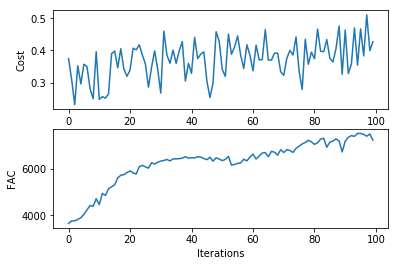

In [23]:
plt.figure()

# Plot average cost values
plt.subplot(211)
plt.plot(cost_values)
plt.xlabel('Iterations')
plt.ylabel('Cost')

# Plot FAC
plt.subplot(212)
plt.plot(fac_values)
plt.xlabel('Iterations')
plt.ylabel('FAC')

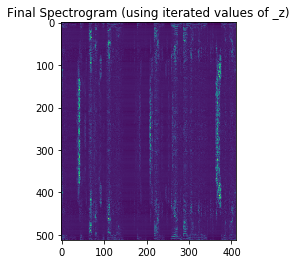

In [25]:
# Generate audio and spectrogram og iterated value of _z
final_audio = sess.run(siamese.get_layer('WaveGAN').output, {siamese.get_layer('LatentVector').input: _z})

final_spectrogram = sess.run(siamese.get_layer('Spectrogram01').output, {siamese.get_layer('LatentVector').input: _z})
# Display spectrogram
plt.figure()
plt.imshow(final_spectrogram[0,:,:,0])
plt.title('Final Spectrogram (using iterated values of _z)')

# Display audio
display(Audio(final_audio[0,:,0], rate=16000))

In [ ]:
# Save audio file for iterated latent vector
master_voice_path = 'master_voice.wav'
sf.write(master_voice_path, final_audio[0,:,0], acoustic_params['sample_rate'])